In [1]:
import numpy as np
import cvxpy as cp

from qutip import coherent, ket2dm, Qobj, expect, fidelity, fock, fock_dm, displace, coherent_dm
from qutip.visualization import plot_wigner_fock_distribution, plot_fock_distribution
from qutip.wigner import qfunc

from tqdm.auto import tqdm # progress bar

import matplotlib.pyplot as plt

from scipy.special import factorial, eval_hermite
from scipy.integrate import quad
from joblib import Parallel, delayed

### Define the harmonic oscillator wavefunction
To create homodyne POVM operators.

In [2]:
def wavefunction(x,n):
    const = 1/(np.sqrt(2**n * factorial(n)) * (np.pi)**0.25 )
    rest = const* np.exp(-x**2/2)
    return float(rest*eval_hermite(n,x))

### Set parameters
Set measurement parameters: number of angles and bins.
Also set Fock space cutoff.

In [3]:
L = 5 # bin limit
Nbins = 20 # number of bins

dx =  2*L/Nbins # bin width

bins = [-L + i*dx for i in range(Nbins)] # list of bins

nangles = 20 # number of angles
thetas = np.linspace(0,np.pi, nangles) # list of all angles

#######
N = 5 # Fock space dimension

### Ideal state:

In [ ]:
rho_ideal = (fock(N,0) + fock(N,1)

### Define homodyne measurement operators

In [4]:
def get_Pis(theta, i):
    Pi = np.zeros((N,N),dtype=np.complex128)
    for m in range(N):
        wave_m = lambda x : wavefunction(x, m)
        for n in range(N):
            wave_n = lambda x: wavefunction(x, n)            
            func = lambda x: wave_m(x)*wave_n(x)
            Pi[n,m] = quad(func, -L + i*dx, -L + (i+1)*dx)[0]*np.exp(-1j*(n-m)*theta)
            
    return Pi*2 #

In [5]:
Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(get_Pis)(theta,i) for theta in thetas for i in range(Nbins))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.3s finished


### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [6]:
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
From `Pis` and `basis_dms`.

In [7]:
def func(index, a):
    return np.trace(Pis[index[0]] @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 8160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 10000 out of 10000 | elapsed:    0.3s finished


### Load homodyne data into $\vec b$

In [8]:
b_all = []
for idx, theta in enumerate(thetas):
    file = 'simulated_homodyne_currents_eta1.0/homodyne_current' + str(idx+1) + '_eta1.00.dat'
    current = np.loadtxt(file)
    #fig,ax=plt.subplots()
    #counts, bins_file, _ = plt.hist(current,Nbins,density=1, range=[-L,L], edgecolor='k')
    counts, bins_file = np.histogram(current,Nbins,density=1, range=[-L,L]);

    b_all.append(counts)
    
b = np.concatenate([array for array in b_all])

## Convex optimization

Define the unknown state as a $N\times N$ Hermitian matrix

In [9]:
X = cp.Variable((N,N), hermitian=True)

Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

WARN: A->p (column pointers) not strictly increasing, column 416 empty
WARN: A->p (column pointers) not strictly increasing, column 422 empty
WARN: A->p (column pointers) not strictly increasing, column 428 empty
WARN: A->p (column pointers) not strictly increasing, column 434 empty
WARN: A->p (column pointers) not strictly increasing, column 440 empty


NameError: name 'ideal_rho' is not defined

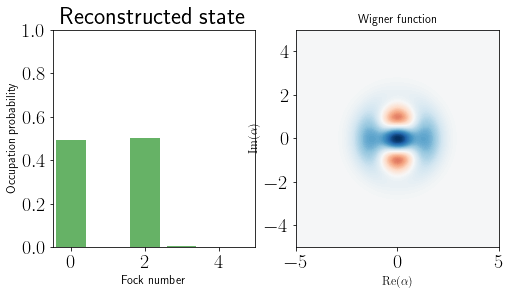

In [10]:
cost = cp.norm(A @ cp.vec(X) - b, 2) 

#Set the trace constraint and positive-semidefinite constraint, respectively.
constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(verbose=False)

# Assign the optimized state X to a Qobj.
reconstructed_rho = Qobj(X.value)

### Visualize results

#Plot the reconstructed state 
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=alpha_max)
ax[0].set_title("Reconstructed state")

f=fidelity(reconstructed_rho, ideal_rho)**2
ax[1].set_title("Fidelity %.3f"%(f))

### Fidelity to ideal superposition of vacuum and 1-photon

In [ ]:
ideal_rho = (fock(N,0) + fock(N,2)).unit()

fidelity(reconstructed_rho, ideal_rho)